## Exercise Yamamoto Method

In this exercise the Yamamoto method will be applied and used as model parameter for the linear region of the steric mass action isotherm.

Import the data given in `./experiments/three_proteins` using the following helper function.
Then, visualize the data.

In [1]:
import numpy as np
from CADETProcess.tools.yamamoto import GradientExperiment
def create_experiment(file_name, gradient_volume):
    """CSV should have format of [time, salt, protein]."""

    data = np.loadtxt(file_name, delimiter=',')
    
    time = data[:, 0]
    c_salt = data[:, 1]
    c_protein = data[:, 2:]
    
    return GradientExperiment(time, c_salt, c_protein, gradient_volume)

In [2]:
experiment_1 = create_experiment('./experiments/three_proteins/18.8mL.csv', 18.8e-6)
experiment_2 = create_experiment('./experiments/three_proteins/37.6mL.csv', 37.6e-6)
experiment_3 = create_experiment('./experiments/three_proteins/56.4mL.csv', 56.4e-6)
experiment_4 = create_experiment('./experiments/three_proteins/75.2mL.csv', 75.2e-6)

experiments = [experiment_1, experiment_2, experiment_3, experiment_4]

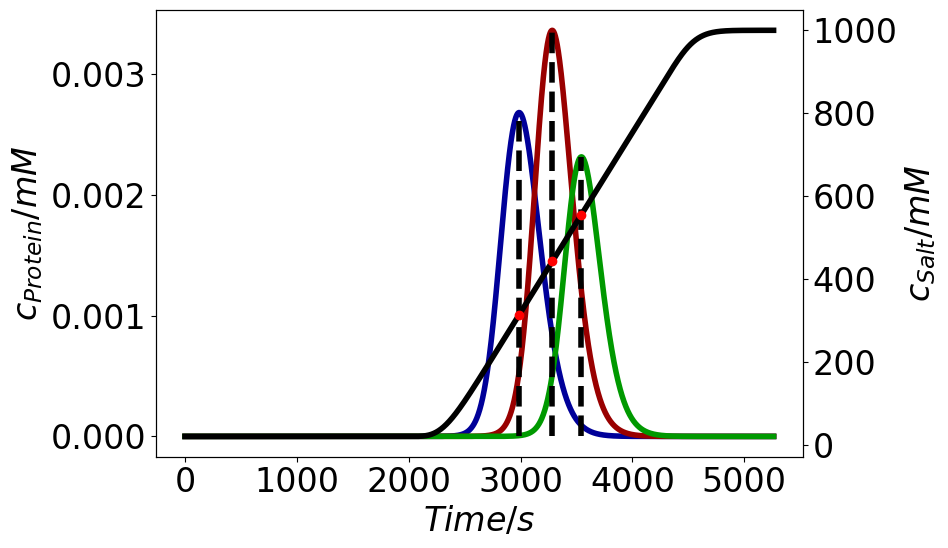

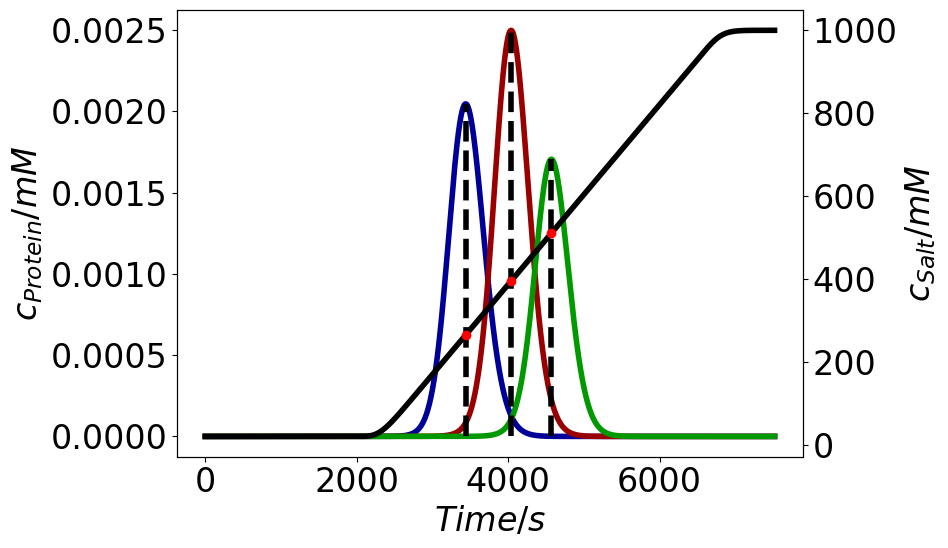

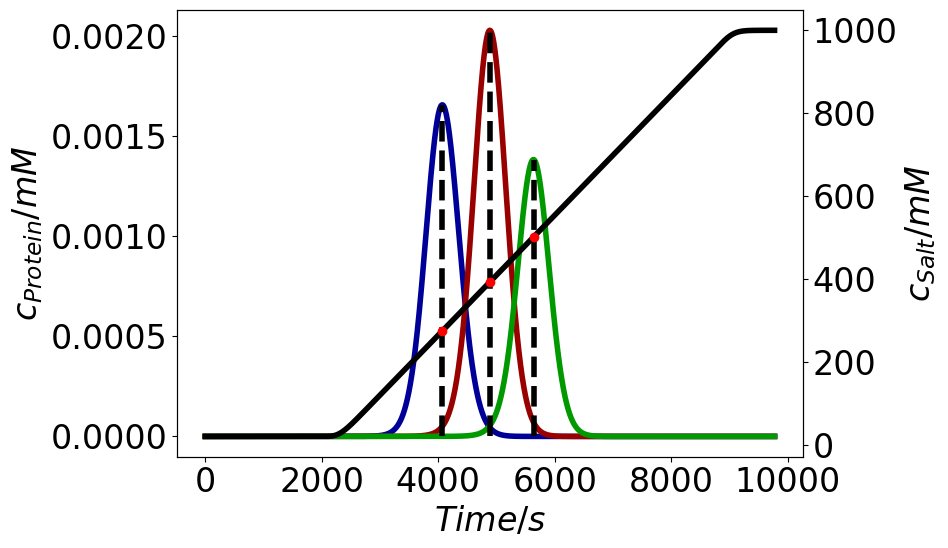

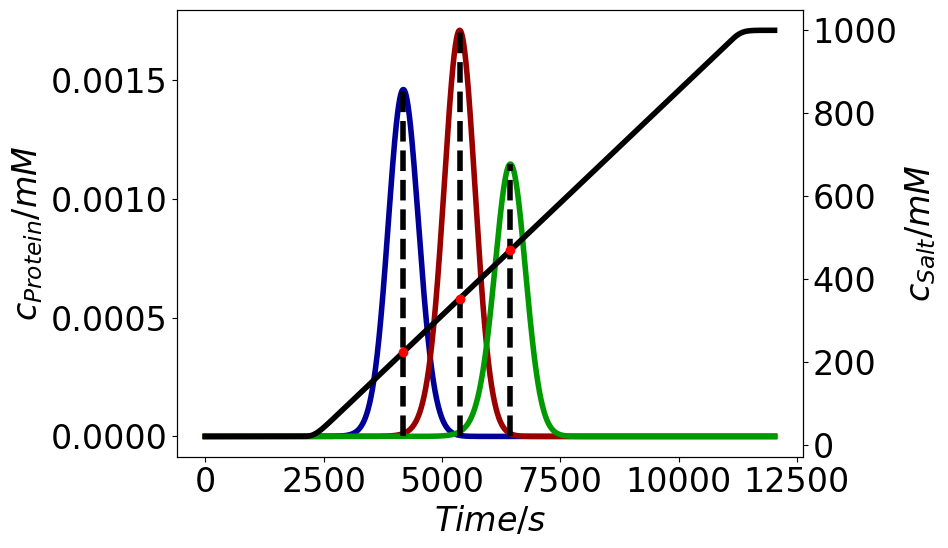

In [3]:
from CADETProcess.tools.yamamoto import plot_experiments

for experiment in experiments:
    experiment.plot()

Define the parameters given in the table below as variables.

Consider the following parameters:
- length: $0.1~m$
- diameter: $7.7~mm$
- bed porosity: $0.36$
- particle radius: $34 \cdot 10^{-6}~m$
- particle porosity: $0.85$

In [19]:
from CADETProcess.processModel import ComponentSystem
component_system = ComponentSystem(['Salt', 'A', 'B', 'C'])

from CADETProcess.processModel import StericMassAction
binding_model = StericMassAction(component_system)
binding_model.adsorption_rate = [1, 1, 1, 1]
binding_model.desorption_rate = [1, 1, 1, 1]
binding_model.capacity = 822.5

In [20]:
from CADETProcess.processModel import LumpedRateModelWithPores
column = LumpedRateModelWithPores(component_system, 'column')
column.binding_model = binding_model
column.length = 0.1
column.diameter = 0.0077
column.bed_porosity = 0.36
column.particle_radius = 34e-6
column.particle_porosity = 0.85

column.axial_dispersion = 1.5e-6
column.film_diffusion = [2e-6, 5e-7, 5e-7, 5e-7]

Apply the Yamamoto method and save the return of the method in a variable. Print the characteristic charge and the equilibrium constant for all proteins in the system.

In [21]:
from CADETProcess.tools.yamamoto import fit_parameters
yamamoto_results = fit_parameters(experiments, column)

print(yamamoto_results.characteristic_charge)
print(yamamoto_results.k_eq)

[2.8304396545666015, 5.198124968084596, 7.4698285458081415]
[0.00027476692596213023, 0.00013243417250352756, 0.00015595241446264102]


Visualize the results of the parameter estimation and check if the results are a good estimate of the experiments.

(<Figure size 1000x600 with 1 Axes>,
 <AxesSubplot: xlabel='Peak Salt Concentration $I_R$ / $M$', ylabel='Normalized Gradient Slope $GH$ / $M$'>)

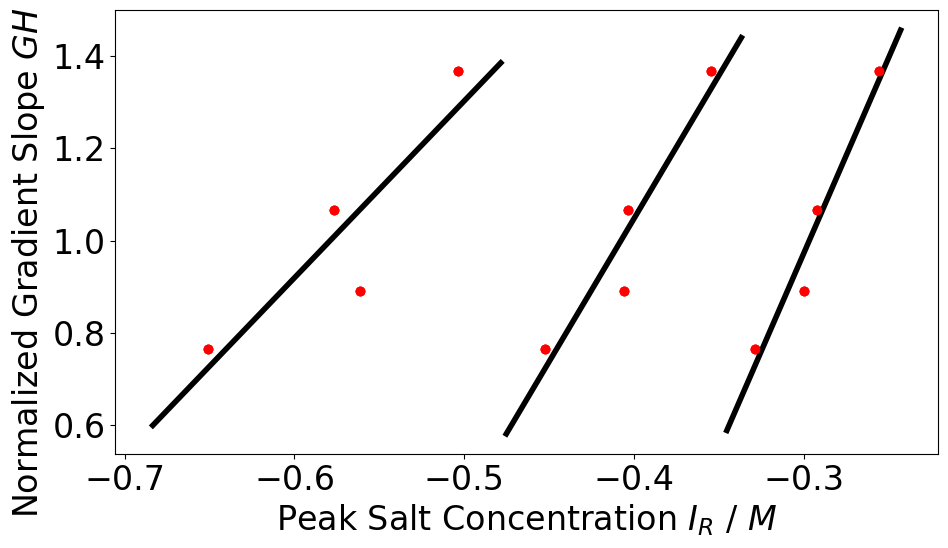

In [22]:
yamamoto_results.plot()

It can be recognized that at least one experiment is not in a good alignment with the found parameter.
Check the output of the parameter estimation and decide which experiment to neglect in the estimation. 

In [23]:
print(f'logarithm of peak salt concentration for Protein 1: {yamamoto_results.log_c_salt_at_max_M[:, 0]}')
print(f'logarithm of peak salt concentration for Protein 2: {yamamoto_results.log_c_salt_at_max_M[:, 1]}')
print(f'logarithm of peak salt concentration for Protein 3: {yamamoto_results.log_c_salt_at_max_M[:, 2]}')
print(f'equilibrium constant: {yamamoto_results.k_eq}')

logarithm of peak salt concentration for Protein 1: [-0.50365037 -0.57681877 -0.56141191 -0.6509448 ]
logarithm of peak salt concentration for Protein 2: [-0.35443582 -0.40334215 -0.40596205 -0.45256616]
logarithm of peak salt concentration for Protein 3: [-0.25563719 -0.2919144  -0.29992008 -0.32879613]
equilibrium constant: [0.00027476692596213023, 0.00013243417250352756, 0.00015595241446264102]


Viewing the data, the third entry related to the third experiment does not fit into the ascending sequence for the peak salt concentration. Remove the third experiment from the parameter estimation and redo the estimation. Also, visualize the results.

In [24]:
experiments_adapted = [experiment_1, experiment_2, experiment_4]
yamamoto_results_adapted = fit_parameters(experiments_adapted, column)

print(yamamoto_results_adapted.characteristic_charge)
print(yamamoto_results_adapted.k_eq)

[3.0873891172594012, 5.135268980773139, 7.229266646829881]
[0.00016795604008843287, 0.00012773935368738274, 0.00016899153582052844]


(<Figure size 1000x600 with 1 Axes>,
 <AxesSubplot: xlabel='Peak Salt Concentration $I_R$ / $M$', ylabel='Normalized Gradient Slope $GH$ / $M$'>)

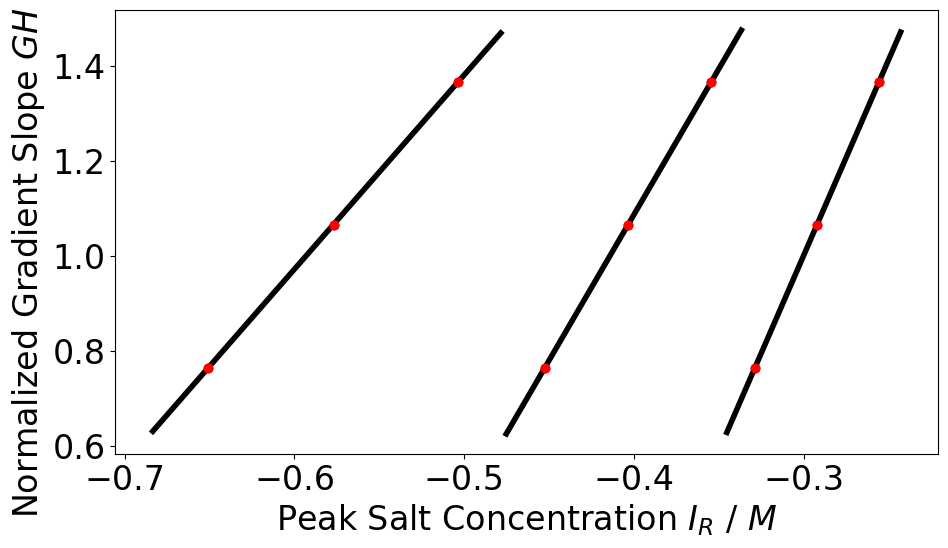

In [25]:
yamamoto_results_adapted.plot()

# Bonus Task

Try to build a simple model which reproduces the experimental results.
The model should consist of an `Inlet`, the column model and an `Outlet`.
Use the values specified in the tables above.

Keep in mind the following steps for creating a model:
1. Specify missing UnitOperations
1. Construct the flow sheet
1. Construct the process
1. Simulation and plotting
1. Comparison to experiment

### 1. Specify missing UnitOperations

In [27]:
from CADETProcess.processModel import Inlet, Outlet

inlet = Inlet(component_system, name='inlet')
inlet.flow_rate = 8.33e-09

outlet = Outlet(component_system, name='outlet')

### 2. Construct the flow sheet

In [28]:
from CADETProcess.processModel import FlowSheet

flow_sheet = FlowSheet(component_system)
flow_sheet.add_unit(inlet)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(inlet, column)
flow_sheet.add_connection(column, outlet)

### 3. Construct the process

In [29]:
from CADETProcess.processModel import Process

flow_rate = 8.33e-09
sample_volume = 50e-9
wash_volume = 15e-6
gradient_volume =18.8e-6 
strip_volume = 10e-6

wash_start = sample_volume/flow_rate
gradient_start = sample_volume/flow_rate + wash_volume/flow_rate
strip_start = sample_volume/flow_rate + wash_volume/flow_rate + gradient_volume/flow_rate 
t_cycle = sample_volume/flow_rate + wash_volume/flow_rate + gradient_volume/flow_rate + strip_volume/flow_rate

slope = ((experiment_1.c_salt_end-experiment_1.c_salt_start)/(gradient_volume/flow_rate))

process = Process(flow_sheet, 'LWE_Lysozyme_18_8mL')
process.cycle_time = t_cycle


process.add_event('load', 'flow_sheet.inlet.c', [experiment_1.c_salt_start,0.2, 0.24,0.16], 0)
process.add_event('wash', 'flow_sheet.inlet.c',[experiment_1.c_salt_start,0,0,0],wash_start)
process.add_event(
    'grad_start',
    'flow_sheet.inlet.c',
    [[experiment_1.c_salt_start,slope],[0,0],[0,0],[0,0]],
    gradient_start_solution-Copy1_solution-Copy1
)
process.add_event('strip','flow_sheet.inlet.c',[experiment_1.c_salt_end,0,0,0],strip_start)

simulator = Cadet()

NameError: name 'gradient_start_solution' is not defined

### 7. Simulation and plotting

In [ ]:
from CADETProcess.simulator import Cadet

simulator = Cadet() 
sim_res = simulator.simulate (process)

from CADETProcess.plotting import SecondaryAxis
sec = SecondaryAxis()
indicies = list(range(1,component_system.n_comp-1))
sec.component_indices = list(range(1,(component_system.n_comp)))
sec.y_label = '$c_{Protein}$'
_ = sim_res.solution.column.outlet.plot(secondary_axis=sec)

### 8. Comparison to experiment

In [ ]:

from CADETProcess.comparison import Comparator, ReferenceIO

comparator = Comparator()
for i_p in range(experiment_1.n_proteins):
    Ref_name = 'Protein_'+str(i_p)
    comparator.add_reference(ReferenceIO(
        Ref_name, experiment_1.time, experiment_1.c_protein[:,i_p]
        )   ) 
    comparator.add_difference_metric(
        'SSE', ReferenceIO(Ref_name, experiment_1.time, experiment_1.c_protein[:,i_p]),
        'outlet.outlet', components=component_system.labels[i_p+1] 
        )

comparator.plot_comparison(sim_res,plot_individual=True)